# Lab 3: Skip-gram Model for Word2Vec

## 1. Downloading the Corpus

In [1]:
import nltk
nltk.download('punkt')
nltk.download('gutenberg')
from nltk.corpus import gutenberg
austen = gutenberg.sents('austen-sense.txt')+gutenberg.sents('austen-emma.txt')+gutenberg.sents('austen-persuasion.txt')

[nltk_data] Downloading package punkt to /home/geminik23/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /home/geminik23/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


Sanity check:
This training corpus contains 16498 sentences. Use the line that follows to ensure that your code
has the same number of lines.

In [2]:
print(len(austen))

16498


## 2. Preprocessing the Training Corpus

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import re

def preprocess_corpus(austen):
    result = []
    sws = stopwords.words('english')
    pattern = r'[!"#$%&\'()*+,-./:;<=>?@\[\\\]^_`{|}~]+'
    for row in austen:
        r = (str.join(' ', row)).lower()
        r = re.sub(pattern, ' ', r)
        res = [e for e in r.split(' ') if e != '' and not e.isdigit() and e not in sws]
        
        
        #if len(res) != 0:
        if len(res) > 1:
            result.append(' '.join(res))
    return result

normalized_corpus = preprocess_corpus(austen)
    

In [4]:
print(normalized_corpus)

['sense sensibility jane austen', 'family dashwood long settled sussex', 'estate large residence norland park centre property many generations lived respectable manner engage general good opinion surrounding acquaintance', 'late owner estate single man lived advanced age many years life constant companion housekeeper sister', 'death happened ten years produced great alteration home supply loss invited received house family nephew mr henry dashwood legal inheritor norland estate person intended bequeath', 'society nephew niece children old gentleman days comfortably spent', 'attachment increased', 'constant attention mr mrs henry dashwood wishes proceeded merely interest goodness heart gave every degree solid comfort age could receive cheerfulness children added relish existence', 'former marriage mr henry dashwood one son present lady three daughters', 'son steady respectable young man amply provided fortune mother large half devolved coming age', 'marriage likewise happened soon after

In [5]:
print('Length of processed corpus:', len(normalized_corpus))
print('Processed line:', normalized_corpus[10])

Length of processed corpus: 15215
Processed line: marriage likewise happened soon afterwards added wealth


## 3. Creating the Corpus Vocabulary and Preparing the Dataset

In [6]:
from keras.preprocessing import text

t = text.Tokenizer()
t.fit_on_texts(normalized_corpus)

word2idx = t.word_index
word_ids = list(word2idx.items())

idx2word = {}

for k,v in word2idx.items():
    idx2word[v] = k
    
    
    
## sents_as_ids
sents_as_ids = []
for sentence in normalized_corpus:
    r = sentence.split(' ')
    sents_as_ids.append([word2idx[ele] for ele in r])

    
# vocab_size and embed_size
vocab_size = len(word_ids) + 1
embed_size = 100


Using TensorFlow backend.


In [7]:
print('Number of unique words:', len(word_ids))
print('\nSample word2idx: ', list(word2idx.items())[:10])  
print('\nSample idx2word:', list(idx2word.items())[:10])
print('\nSample normalized corpus:', normalized_corpus[:3])
print('\nAbove sentence as a list of ids:' , sents_as_ids[:3])

Number of unique words: 10160

Sample word2idx:  [('could', 1), ('would', 2), ('mr', 3), ('mrs', 4), ('must', 5), ('said', 6), ('one', 7), ('much', 8), ('miss', 9), ('every', 10)]

Sample idx2word: [(1, 'could'), (2, 'would'), (3, 'mr'), (4, 'mrs'), (5, 'must'), (6, 'said'), (7, 'one'), (8, 'much'), (9, 'miss'), (10, 'every')]

Sample normalized corpus: ['sense sensibility jane austen', 'family dashwood long settled sussex', 'estate large residence norland park centre property many generations lived respectable manner engage general good opinion surrounding acquaintance']

Above sentence as a list of ids: [[310, 1394, 76, 4325], [110, 102, 59, 342, 2424], [1039, 410, 1642, 606, 563, 2800, 1040, 67, 4326, 511, 778, 161, 1180, 198, 14, 195, 3064, 148]]


## 4. Generating training instances

In [8]:
from keras.preprocessing.sequence import skipgrams
skip_grams = [skipgrams(sent, vocabulary_size=vocab_size, window_size=5) for sent in
sents_as_ids]


In [10]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(len(pairs)):
    print('({:s} ({:d}), {:s} ({:d})) -> {:d}'.format(
        # the first word and its index
        idx2word[pairs[i][0]], pairs[i][0],
        # the second word and its index
        idx2word[pairs[i][1]], pairs[i][1],
        # the label
        labels[i]))

(sensibility (1394), reassembled (8587)) -> 0
(austen (4325), jane (76)) -> 1
(sensibility (1394), jane (76)) -> 1
(jane (76), sensibility (1394)) -> 1
(sensibility (1394), persuasion (984)) -> 0
(jane (76), austen (4325)) -> 1
(austen (4325), reckons (7558)) -> 0
(jane (76), sense (310)) -> 1
(sense (310), sensibility (1394)) -> 1
(austen (4325), fame (3481)) -> 0
(jane (76), stipulation (8547)) -> 0
(sense (310), austen (4325)) -> 1
(sensibility (1394), austen (4325)) -> 1
(sensibility (1394), valueless (6916)) -> 0
(sense (310), stop (1129)) -> 0
(austen (4325), refreshment (4779)) -> 0
(sensibility (1394), sense (310)) -> 1
(sense (310), cork (9442)) -> 0
(austen (4325), sense (310)) -> 1
(jane (76), infection (3654)) -> 0
(austen (4325), sensibility (1394)) -> 1
(sense (310), woe (9509)) -> 0
(sense (310), jane (76)) -> 1
(jane (76), arranger (9503)) -> 0


## 5. Building the Skip-gram Neural Network Architecture

In [11]:
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import plot_model



target_word = Input((1,), dtype='int32')
target_embedding = Embedding(vocab_size, 
                             embed_size, 
                             name='target_embed_layer', 
                             embeddings_initializer='glorot_uniform', 
                             input_length=1)(target_word)

target_input = Reshape((embed_size, ))(target_embedding)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
context_word = Input((1,), dtype='int32')
context_embedding = Embedding(vocab_size, 
                             embed_size, 
                             name='context_embed_layer', 
                             embeddings_initializer='glorot_uniform', 
                             input_length=1)(context_word)
context_input = Reshape((embed_size, ))(context_embedding)

In [14]:
merged_inputs = Dot(axes=-1, normalize=False)([target_input, context_input])

In [15]:
label = Dense(1, input_shape=(1,), activation='sigmoid', kernel_initializer='glorot_uniform')(merged_inputs)

In [16]:
from keras import optimizers
model = Model(inputs=[target_word, context_word], outputs=[label]) # label is the output of step D.
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='mse', metrics=['accuracy'])

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
target_embed_layer (Embedding)  (None, 1, 100)       1016100     input_1[0][0]                    
__________________________________________________________________________________________________
context_embed_layer (Embedding) (None, 1, 100)       1016100     input_3[0][0]                    
____________________________________________________________________________________________

You can also visualize the model architecture.

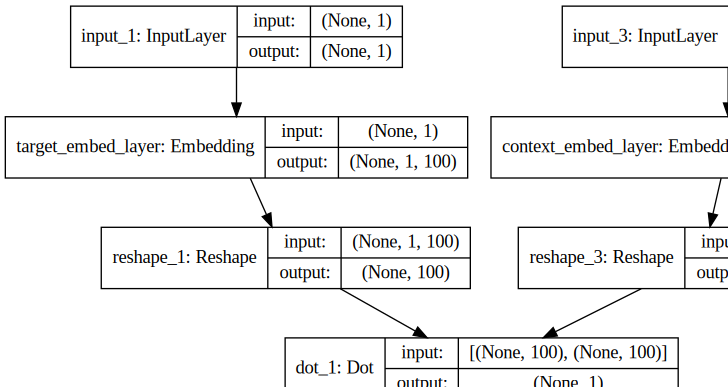

In [18]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [21]:
import numpy as np


for epoch in range(1, 6):
    epoch_loss = 0
    # in each epoch, train all the sentences, one per iteration=> batch_size = num_sents
    for i, sent_examples in enumerate(skip_grams):
        target_wds = np.array([pair[0] for pair in sent_examples[0]], dtype='int32')
        context_wds = np.array([pair[1] for pair in sent_examples[0]], dtype='int32')
        labels = np.array(sent_examples[1], dtype='int32')
        X = [target_wds, context_wds]
        Y = labels
        if i % 5000 == 0: # after 5000 sentences i.e. 5000 iterations
            print('Processed %d sentences' %i)
        epoch_loss += sum(model.train_on_batch(X, Y))
    print('Processed all %d sentences' %i)
    print('Epoch:', epoch, 'Loss:', epoch_loss, '\n')

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed 15000 sentences
Processed all 15214 sentences
Epoch: 1 Loss: 13969.305797801702 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed 15000 sentences
Processed all 15214 sentences
Epoch: 2 Loss: 14340.721943441546 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed 15000 sentences
Processed all 15214 sentences
Epoch: 3 Loss: 14466.540321377339 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed 15000 sentences
Processed all 15214 sentences
Epoch: 4 Loss: 14539.00634886531 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed 15000 sentences
Processed all 15214 sentences
Epoch: 5 Loss: 14537.154821343393 



## 7. Getting the Word Embeddings

In [25]:
word_embeddings = model.get_layer('target_embed_layer').get_weights()[0][1:] # Recall that 0 was left for padding

In [27]:
print(word_embeddings.shape)

from pandas import DataFrame
print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

(10160, 100)
             0         1         2         3         4         5         6   \
could  0.065592  0.232955  0.245242 -0.023286  0.126981 -0.203632  0.085448   
would  0.066267 -0.074835  0.291644 -0.056279 -0.136118 -0.098399  0.020581   
mr    -0.195421 -0.002064 -0.102707  0.043951 -0.039613 -0.163788  0.071105   
mrs    0.044538  0.100877 -0.069204  0.147988 -0.157658 -0.086987 -0.354028   
must  -0.018121 -0.047016  0.172152 -0.037749 -0.013794 -0.016774  0.031694   
said   0.122238  0.171963 -0.107397 -0.004257 -0.045900 -0.073258  0.036427   
one    0.038606 -0.049598 -0.043891 -0.008409 -0.061701  0.156832 -0.043801   
much  -0.207200  0.185513 -0.037252 -0.070559 -0.058420 -0.066957  0.031900   
miss  -0.071468 -0.056975 -0.025887  0.096782 -0.011998 -0.045610 -0.173087   
every  0.050339  0.109324 -0.083741 -0.043340  0.054121  0.300718  0.033559   

             7         8         9   ...        90        91        92  \
could  0.022327 -0.009188  0.004296  ...  0

## 8. Measuring Similarity Between Word Pairs

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(word_embeddings)

In [30]:
print(similarity_matrix.shape)

(10160, 10160)


## 9. Exploring and Visualizing your Word Embeddings using t-SNE

A. Get the most similar words to the search items in the list below

In [32]:
search_items = ['man', 'love', 'hatred', 'woman', 'wisdom', 'kindness', 'god', 'man', 'folly', 'fool']
similar_words = {term: [idx2word[idx] for idx in (-1 * similarity_matrix[word2idx[term]-1]).argsort()[1:6] + 1] for term in search_items}

In [33]:
print(similar_words)

{'man': ['woman', 'consider', 'gentleman', 'women', 'wentworth'], 'love': ['found', 'father', 'received', 'elliot', 'smith'], 'hatred': ['porker', 'renounced', 'madeira', 'eyebrows', 'reserves'], 'woman': ['means', 'extremely', 'happy', 'offer', 'quite'], 'wisdom': ['dependent', 'dissented', 'acquiescence', 'accelerate', 'nourishing'], 'kindness': ['entirely', 'terms', 'happy', 'shall', 'seem'], 'god': ['listened', 'unhappy', 'ball', 'undertaken', 'disposed'], 'folly': ['partialities', 'surveyor', 'hunters', 'pattern', 'crushed'], 'fool': ['merrier', 'quarrelled', 'asp', 'profess', 'colder']}


B. Plot the words in the dictionary above using t-SNE

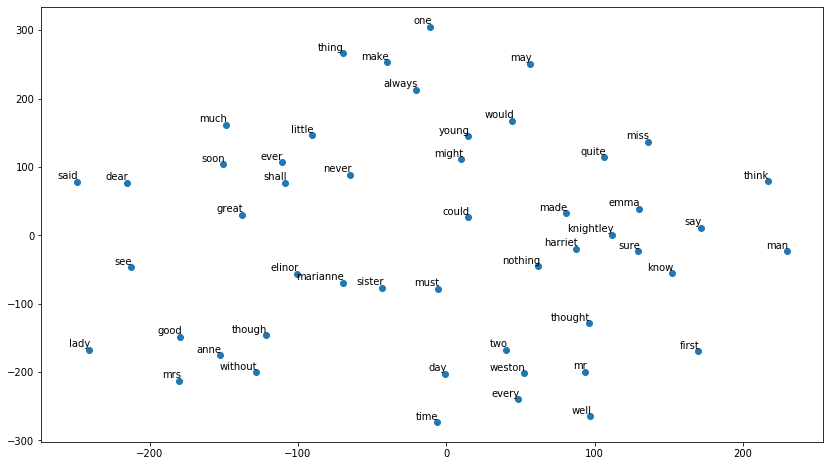

In [36]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50
T = tsne.fit_transform(word_embeddings[:plot_only, :])
labels = [idx2word[i+1] for i in range(plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')
plt.show()